In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import util as u
import pipeline as p
import assess_clf_models as acm
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour, OneSidedSelection, InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, SMOTENC
from imblearn.under_sampling import ClusterCentroids, NearMiss, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.combine import SMOTEENN, SMOTETomek

## Load Data

Prepared / cleaned in 'DataPrep' notebook

In [3]:
X_train1 = u.open_pkl('Data/X_train_10yrs.pkl')
y_train1 = u.open_pkl('Data/y_train_10yrs.pkl')

### Create sub-set of dataset
10% of data, to expedite testing of models

In [23]:
size_X = len(X_train1)
rand_idx = np.random.randint(0, size_X - 1, size=int(size_X*0.1))
mini_X = X_train1.loc[rand_idx]
mini_y = pd.Series([y_train1.iloc[x] for x in rand_idx])
mini_X.reset_index(inplace=True, drop=True)
print(len(mini_X))

28974


### Features

Exclude:
- num_lipinski_ro5_violations: From initial/MVP model, had nearly 0 importance.
- acd_most_apka & acd_most_bpka have high % nulls.
- synonyms: wouldn't be "known" at time of initial assaying of molecule.
- year: not germaine or accurate. need to use to drop entries, however.
- org_ids
- keep only num_alerts_set1. Exclude others.

Might be leaky: (would these be known at time of "discovery" of molecule?)
- num_docs
- num_targets
- num_activities & num_assays

Encode:
- molecular_species: one-hot
- target_classes: n-hot
- assay_types: n-hot

Engineer / Combine:
- num_activities & num_assays: they are correlated. take average

# Develop pipeline

### Define columns to include in model
not sure I need this, but good to have a list

In [5]:
col_features = ['mw_freebase', 'alogp', 'acd_logp', 'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass',
       'num_ro5_violations', 'molecular_species', 'aromatic_rings', 'heavy_atoms', 'qed_weighted',
       'hba_lipinski', 'hbd_lipinski', 'research_co', 'target_classes', 'human_target', 
        'num_target_organisms', 'assay_types', 'num_alerts_set1']

# test_X = mini_X[col_features]

### Count-Vectorize - target_classes & assay_classes
Need to impute missing values in target_classes first

In [6]:
# tar_cls_col = list(mini_X.columns).index('target_classes')
asy_cls_col = list(mini_X.columns).index('assay_types')

preproc_target = Pipeline([
        ('impute', p.TargetClassImputer()),
        ('target_cv', p.target_transformer)
])

preproc_assay = ColumnTransformer(transformers=[
            ('assay_cv', p.assay_transformer, asy_cls_col)
])

# Count Vectorizer requires column indices in scalar format
preproc_cv = Pipeline([
    ('cv', FeatureUnion([
        ('assays', preproc_assay),
        ('targets', preproc_target)
        ])),
    ('densify', FunctionTransformer(p.densify, validate=False))
])

In [7]:
preproc_assay.fit(mini_X)
feat_cv_asy = preproc_assay.named_transformers_['assay_cv'].get_feature_names()

preproc_target.fit(mini_X)
feat_cv_trg = preproc_target.named_steps['target_cv'].get_feature_names()

feat_cv_asy = ['assay_class_' + x for x in feat_cv_asy]
feat_cv_trg = ['target_' + x for x in feat_cv_trg]

In [24]:
trX = preproc_target.fit_transform(mini_X)
df = pd.DataFrame(trX.toarray(), columns=feat_cv_trg)

ex = mini_X.rename(columns={'target':'target_names','target_classes':'target'})

ex.loc[0:3,['target', 'assay_types']]

,target,assay_types
0,UNDEFINED,F
1,"UNDEFINED,NON-MOLECULAR,PROTEIN",F
2,PROTEIN,"B,F"
3,"UNDEFINED,NON-MOLECULAR","A,U,F"


In [25]:
df.head(4)

,target_molecular,target_non-molecular,target_protein,target_undefined
0,0,0,0,1
1,0,1,1,1
2,0,0,1,0
3,0,1,0,1


### One-hot-Encode - other categorical features

In [28]:
cols_to_encode = ['molecular_species']
cols_to_encode_idx = [list(mini_X.columns).index(x) for x in cols_to_encode]

# OneHotEncoder requires columns indices in list format
preproc_ohe = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), cols_to_encode_idx)])

In [129]:
preproc_ohe.fit(mini_X)
feat_ohe = preproc_ohe.named_transformers_['cat'].get_feature_names()
feat_ohe = feat_ohe.tolist()


### Scale - sub-set of numeric

In [29]:
cols_to_scale = ['mw_freebase', 'alogp', 'acd_logp', 'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 
       'num_ro5_violations', 'aromatic_rings', 'heavy_atoms', 'hba_lipinski', 'hbd_lipinski',  
       'num_target_organisms', 'num_alerts_set1']
cols_to_scale_idx = [list(mini_X.columns).index(x) for x in cols_to_scale]


preproc_scale = ColumnTransformer(transformers=[
        ('num', StandardScaler(), cols_to_scale_idx), 
    ], remainder='drop')    

In [116]:
feat_num = cols_to_scale

### Features to keep as-is

They are boolen-encoded. 1 = yes/True, 0 = no/False

In [30]:
cols_to_pass = ['ro3_pass', 'research_co','human_target']
cols_to_pass_idx = [list(mini_X.columns).index(x) for x in cols_to_pass]


preproc_pass = ColumnTransformer(transformers=[
        ('as_is', 'passthrough', cols_to_pass_idx), 
])

preproc_pass_num = ColumnTransformer(transformers=[
        ('as_is', 'passthrough', cols_to_scale_idx), 
])

In [117]:
feat_pass = cols_to_pass

### Feature Engineering

New as of 02d-01:
- Take average of num_targets & num_activities. There were highly correlated

In [31]:
# num_asy_col = [list(mini_X.columns).index('num_assays')]

feat_eng1 = Pipeline([
    ('avg', p.TargetActivityAvg()),
    ('reshape', FunctionTransformer(p.reshaper, validate=False))
])

feat_eng2 = Pipeline([
        ('ratio',  p.AssayRatio()),
        ('reshape', FunctionTransformer(p.reshaper, validate=False)),
        ])

preproc_feat_eng = Pipeline([
    ('feat_eng', FeatureUnion([
        ('avg', feat_eng1),
        ('ratio', feat_eng2)
    ]))
])

preproc_feat_eng_scaled = Pipeline([
    ('feat_eng', FeatureUnion([
        ('avg', feat_eng1),
        ('ratio', feat_eng2)
    ])),
    ('scale', StandardScaler())
])

In [119]:
feat_fe = ['avg_num_targ_act', 'ratio_assay_avg_targ_act']


## Sew them all together

#### Includes scaling

In [32]:
pipe_with_scale = Pipeline([
    ('all', FeatureUnion([
        ('cvs', preproc_cv),
        ('feat_eng', preproc_feat_eng_scaled),
        ('ohe', preproc_ohe), 
        ('pass', preproc_pass),
        ('num', preproc_scale),
    ])
    )
])

#### Categorical only

In [33]:
preproc_pass = ColumnTransformer(transformers=[
        ('as_is', 'passthrough', cols_to_pass_idx), 
])

pipe_cat_only = Pipeline([
    ('all', FeatureUnion([
        ('cvs', preproc_cv),
        ('feat_eng', preproc_feat_eng),
        ('ohe', preproc_ohe), 
        ('pass', preproc_pass),
        ('num', preproc_pass_num)
    ])
    )
])

In [130]:
# Feature names for pipe_cat_only & pipe_with_scale
feat_names = feat_cv_asy + feat_cv_trg + feat_fe + feat_ohe + feat_pass + feat_num

#### Cat Boost
needs different pre-processing

In [34]:
other_cb_features = ['mw_freebase', 'alogp', 'acd_logp', 'acd_logd', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass',
       'num_ro5_violations', 'molecular_species', 'aromatic_rings', 'heavy_atoms', 'qed_weighted',
       'hba_lipinski', 'hbd_lipinski', 'research_co', 'num_target_organisms',
        'human_target', 'num_target_organisms', 'num_alerts_set1']
other_cb_feat_idx = [list(mini_X.columns).index(x) for x in other_cb_features]

preproc_pass_cb = ColumnTransformer(transformers=[
        ('as_is', 'passthrough', other_cb_feat_idx), 
])

pipe_cat_boost = Pipeline([
    ('all', FeatureUnion([
        ('cvs', preproc_cv),
        ('feat_eng', preproc_feat_eng),
        ('pass', preproc_pass_cb)
    ])
    )
])

# where the "categorical" columns end up after the above pre-processing
# (I determined this manually -- couldn't figure out a way to do it automatically)
cab_cat_feats = ['ro3_pass', 'molecular_species', 'research_co', 'human_target']
cb_cat_cols = [20, 22, 28, 30]

In [131]:
feat_other_cb = other_cb_features

# for pipe_cat_boost:
feat_names_cb = feat_cv_asy + feat_cv_trg + feat_fe + feat_other_cb

#### Save pipelines & feature name

In [16]:
u.pkl_this('Data/Models/cat_boost_preproc_01.pkl', pipe_cat_boost)
u.pkl_this('Data/Models/cat_boost_categ_cols.pkl', cb_cat_cols)
u.pkl_this('Data/Models/preproc_scaler.pkl', pipe_with_scale)
u.pkl_this('Data/Models/preproc_cat.pkl', pipe_cat_only)
u.pkl_this('Data/Models/cat_boost_feature_names.pkl', feat_names_cb)

## Test out models

- Within crossvalidation:
    - preprocess (scale, one-hot-encode)
    - fit model
    - assess on test / hold-out portion

In [23]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_bal = LogisticRegression(class_weight='balanced')
rand_for = RandomForestClassifier(n_estimators=10)
grad_boost = GradientBoostingClassifier()
cb = CatBoostClassifier(cat_features=cb_cat_cols, logging_level='Silent')
dtb = BaggingClassifier(base_estimator=DecisionTreeClassifier())

In [42]:
mini_results_lr = acm.assess_model(pipe_with_scale, log_reg, mini_X, mini_y)
mini_results_lr2 = acm.assess_model(pipe_with_scale, log_reg_bal, mini_X, mini_y)
mini_results_rf = acm.assess_model(pipe_cat_only, rand_for, mini_X, mini_y)
mini_results_gb = acm.assess_model(pipe_cat_only, grad_boost, mini_X, mini_y)
mini_results_dtb = acm.assess_model(pipe_cat_only, dtb, mini_X, mini_y)
mini_results_cb = acm.assess_model(pipe_cat_boost, cb, mini_X, mini_y)

In [43]:
comp_df = pd.DataFrame([mini_results_lr, mini_results_lr2, mini_results_rf, mini_results_gb, mini_results_dtb, 
                        mini_results_cb],
             index=['LogReg','LogReg-bal','RandFor','GradBst','Bagged-DecTr', 'Cat Boost'])
comp_df

,Precision-0,Recall-0 (Specificty),F1score-0,Precision-1,Recall-1 (Sensitivity),F1score-1,TN,FN,FP,TP,AUC,Accuracy
LogReg,0.997620,0.999717,0.998668,0.801678,0.310638,0.443966,13415.8,32.0,3.8,14.4,0.953200,0.997341
LogReg-bal,0.999553,0.933053,0.965156,0.043514,0.879371,0.082914,12521.2,5.6,898.4,40.8,0.961740,0.932868
RandFor,0.997695,0.999821,0.998757,0.885333,0.332100,0.476129,13417.2,31.0,2.4,15.4,0.854003,0.997520
GradBst,0.997664,0.999359,0.998511,0.639934,0.323589,0.426096,13411.0,31.4,8.6,15.0,0.952465,0.997030
Bagged-DecTr,0.997798,0.999463,0.998630,0.697699,0.362072,0.473903,13412.4,29.6,7.2,16.8,0.839191,0.997267
Cat Boost,0.997947,0.999553,0.998749,0.761822,0.405643,0.523980,13413.6,27.6,6.0,18.8,0.981397,0.997505


#### Conclusions:
- Use Precision(1) as metric: want to be confident that something I predict to be approved will be
    - `acm.assess_model_precision(preproc, model, mini_X, mini_y)`
- Thus, Logistic Regression (**without** balanced classes)performed the best, then Random Forest & Bagged Decision Trees. 
- Address imbalance

#### Aside: which features are important?

In [446]:
pipeline = Pipeline(steps = [('prepro', pipe_with_scale), ('clf', log_reg)])
model_lf = pipeline.fit(mini_X, mini_y)

In [447]:
fis = pipeline.named_steps['clf'].coef_[0]

In [448]:
fi_list = list(zip(feat_names, fis))
fi_list.sort(reverse=False, key=lambda x: x[1])

labels = [x[0] for x in fi_list]
imp = [x[1] for x in fi_list]

<BarContainer object of 34 artists>

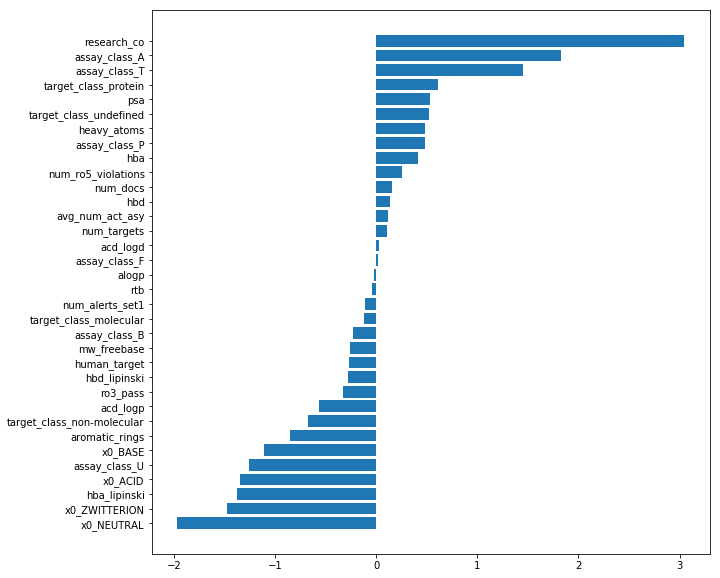

In [449]:
plt.figure(figsize=(10,10))
plt.barh(y=range(len(fi_list)), width=list(zip(*fi_list))[1], tick_label = list(zip(*fi_list))[0])
# plt.barh(y=range(len(fis[0])), width = fis_sorted)

In [461]:
pipeline2 = Pipeline(steps = [('prepro', pipe_cat_only), ('clf', rand_for)])
model_rf = pipeline2.fit(mini_X, mini_y)

In [462]:
fis2 = pipeline2.named_steps['clf'].feature_importances_

In [463]:
len(fis2)

34

<BarContainer object of 34 artists>

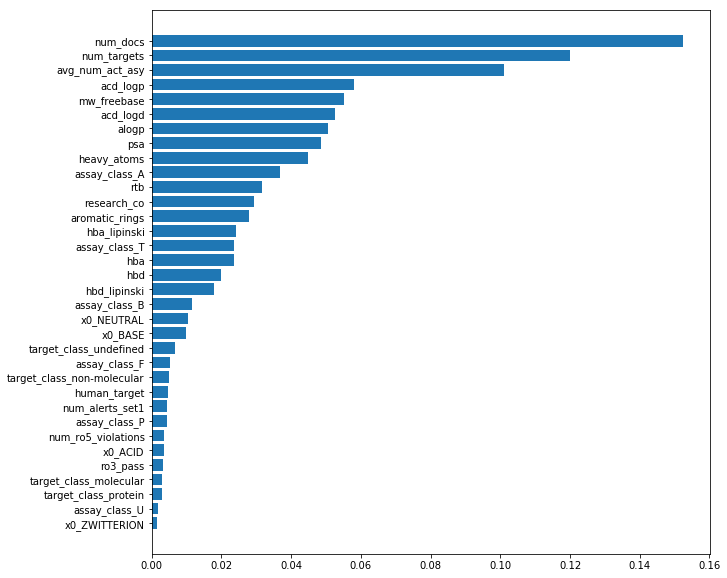

In [464]:
fi_list2 = list(zip(feat_names, fis2))
fi_list2.sort(reverse=False, key=lambda x: x[1])

labels = [x[0] for x in fi_list2]
imp = [x[1] for x in fi_list2]

plt.figure(figsize=(10,10))
plt.barh(y=range(len(fi_list2)), width=list(zip(*fi_list2))[1], tick_label = list(zip(*fi_list2))[0])

In [454]:
#try this?
rf2 = RandomForestClassifier(oob_score=True, class_weight='balanced')

## Imbalance

In [549]:
# lists to track results
rf_resamp_list = []
lr_resamp_list = []

rf_resamp_list.append(['Baseline', acm.assess_model_precision(pipe_cat_only, rand_for, mini_X, mini_y)])
lr_resamp_list.append(['Baseline', acm.assess_model_precision(pipe_with_scale, log_reg, mini_X, mini_y)])

In [469]:
seed = 19

#### Dealing with Mixed Features

SMOTE-NC is the only `imblearn` method which can handle mixed features. Even then, it cannot handle my target_classes and assay_types, which are lists. And, I would still need to impute target na's before. It's not worth creating a specific preprocessor to handle it. 

Use 'pipe_cat_only' to convert categorical variables prior to resampling with imblearn methods:

In [615]:
X_for_res_cat = pipe_cat_only.fit_transform(mini_X)


Need to treat scale-only slightly different than we did above, as the indices get changed up once we fit_transform. Still need to impute & transform categorical variable before we pass into imblearn methods; perform StandaradScaling inside cross-validation.

In [620]:
preproc_res_scaler = Pipeline([
    ('all', FeatureUnion([
        ('cvs', preproc_cv),
        ('feat_eng', preproc_act_asy),
#         ('pass_fe', preproc_pass_fe),
        ('ohe', preproc_ohe), 
        ('pass', preproc_pass),
        ('num', preproc_pass_num)
    ])
    ),
    ('densify', FunctionTransformer(p.densify, validate=False))    
])

In [609]:
cols_scale_res_idx = [feat_names.index(x) for x in cols_to_scale] + [feat_names.index('avg_num_act_asy')]

In [618]:
pipe_scale = ColumnTransformer(transformers= [
    ('scaler', StandardScaler(), cols_scale_res_idx)
])

### Over-sampling

In [545]:
res = SMOTE(randome_state=seed)

rf_sm = acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)
rf_resamp_list.append(["Smote", rf_sm])


lr_sm = acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)
lr_resamp_list.append(["Smote", lr_sm])


In [628]:
res = ADASYN(random_state=seed)

rf_resamp_list.append(["ADASYN", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["ADASYN", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

### Under-sampling

In [635]:
res = RandomUnderSampler(random_state=seed)

rf_resamp_list.append(["RandomUnder", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["RandomUnder", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

In [638]:
res = EditedNearestNeighbours(random_state=seed)

rf_resamp_list.append(["ENN", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["ENN", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

In [641]:
res = NearMiss(random_state=seed, version=3)

rf_resamp_list.append(["NearMiss3", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["NearMiss3", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

In [644]:
res = NearMiss(random_state=seed, version=1)

rf_resamp_list.append(["NearMiss1", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["NearMiss1", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

### Ensemble

In [631]:
res = SMOTEENN(random_state=seed)

rf_resamp_list.append(["SMOTE-EEN", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["SMOTE-EEN", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

In [632]:
res = SMOTETomek(random_state=seed)

rf_resamp_list.append(["SMOTE-Tomek", 
                       acm.assess_model_only_with_resamp_prec(rand_for, res, X_for_res_cat, mini_y)])

lr_resamp_list.append(["SMOTE-Tomek", 
                       acm.assess_model_with_resamp_prec(pipe_scale, log_reg, res, X_for_res_scale, mini_y)])

In [ ]:
lr_resamp_list

In [645]:
rf_resamp_list

[['Baseline', 0.7536942355889724],
 ['Smote', 0.6949509803921567],
 ['ADASYN', 0.6727194227194226],
 ['SMOTE-EEN', 0.5159946840228878],
 ['SMOTE-Tomek', 0.6332809875896965],
 ['RandomUnder', 0.059763158004542405],
 ['ENN', 0.6453479853479853],
 ['NearMiss3', 0.006595497666855373],
 ['NearMiss1', 0.009948276060309433]]

None of these improved the base (imbalanced) model 